In [1]:
import geopandas as gpd
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import modin.pandas as pd
import numpy as np
import shapely
from modin.config import ProgressBar
from tqdm.auto import tqdm
import seaborn as sns

ProgressBar.enable()

In [2]:
wforms = (
    pd.read_parquet("wforms-bat.parquet")
    .join(pd.read_parquet("wforms-ann.parquet", columns=["status"]), how="left")
    .join(pd.read_parquet("wforms-occ.parquet", columns=["rho", "tot", "fst", "lst", "top", "cvx"]).add_suffix("_occ"), how="left")
    .join(pd.read_parquet("wforms-usr.parquet", columns=["rho", "tot"]).add_suffix("_usr"), how="left")
)

To remove this warning, run the following python code before doing dataframe operations:

    import ray
    ray.init()

2024-02-02 16:15:10,081	INFO worker.py:1621 -- Started a local Ray instance.


Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

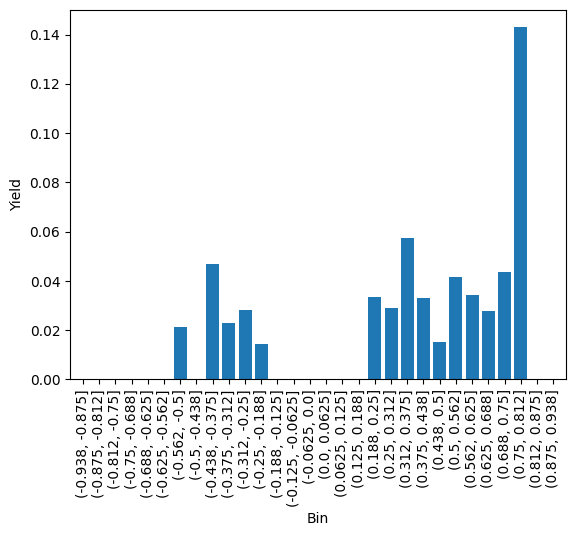

In [48]:
# Q: is there any pattern in the local yield over rho_occ for |rho_occ| >= 0.2?
# A: yeah, positive values are better, esp. above 0.7 (so Grieve's choice of 0.8 makes sense)

subset = wforms[abs(wforms["rho_occ"]).ge(0.2)][["rho_occ", "status"]]
subset['bin'] = pd.cut(subset['rho_occ'], np.arange(-1, 1 + 1/16, 1/16))
y = subset[subset['status'].ge(1)].groupby('bin').size() / subset.groupby('bin').size()

plt.bar([str(i) for i in y.index], y)
plt.xlabel('Bin')
plt.ylabel('Yield')
plt.xticks(rotation=90)
plt.show()

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

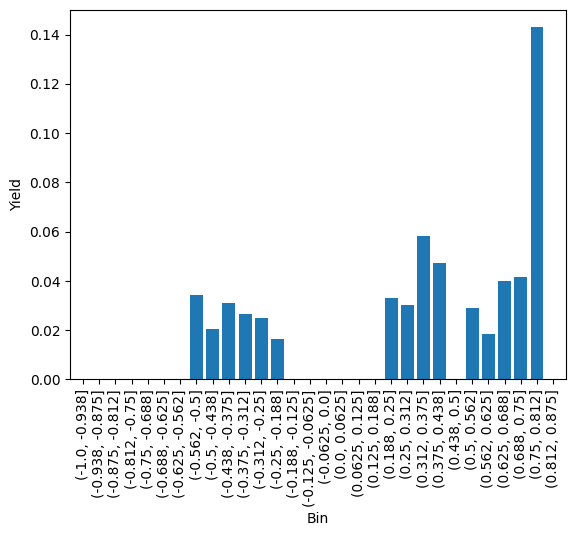

In [49]:
# Q: is there any pattern in the local yield over rho_usr for |rho_usr| >= 0.2?
# A: yeah, same thing as rho_occ

subset = wforms[abs(wforms["rho_usr"]).ge(0.2)][["rho_usr", "status"]]
subset['bin'] = pd.cut(subset['rho_usr'], np.arange(-1, 1 + 1/16, 1/16))
y = subset[subset['status'].ge(1)].groupby('bin').size() / subset.groupby('bin').size()

plt.bar([str(i) for i in y.index], y)
plt.xlabel('Bin')
plt.ylabel('Yield')
plt.xticks(rotation=90)
plt.show()

Estimated completion of line 1:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 2:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 3:   0%           Elapsed time: 00:00, estimated remaining time: ?

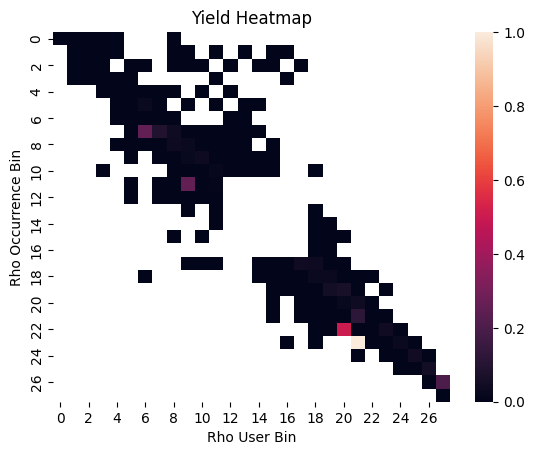

In [44]:
# Q: is there any pattern considering both |rho_occ| >= 0.2 and |rho_usr| >= 0.2?
# A: kinda, they clearly correlate, and there are a couple of hot spots

subset = wforms[abs(wforms["rho_occ"]).ge(0.2) | abs(wforms["rho_usr"]).ge(0.2)][["rho_occ", "rho_usr", "status"]]
subset['bin_rho_occ'] = pd.cut(subset['rho_occ'], np.arange(-1, 1 + 1/16, 1/16))
subset['bin_rho_usr'] = pd.cut(subset['rho_usr'], np.arange(-1, 1 + 1/16, 1/16))
y = subset.pivot_table(values='status', index='bin_rho_occ', columns='bin_rho_usr', aggfunc=lambda xs: xs.eq(1).sum()/len(xs))

ax = sns.heatmap(y)
ax.set_xlabel('Rho User Bin')
ax.set_ylabel('Rho Occurrence Bin')
ax.set_title('Yield Heatmap')
plt.show()

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

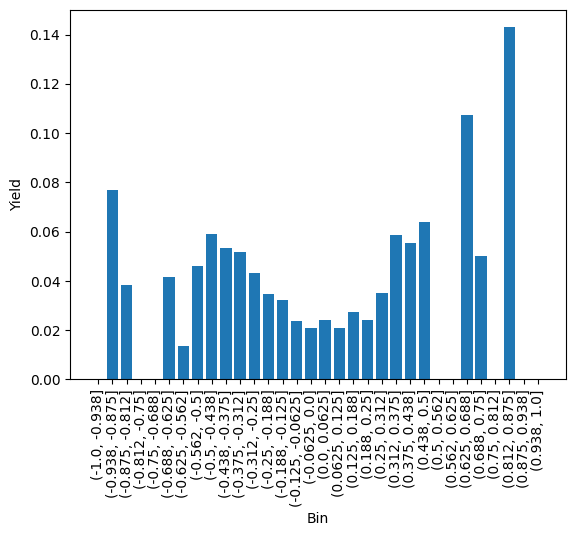

In [33]:
# Q: is there any pattern on the convexity of subset B?
# A: at first glance, it looks weirdly bimodal!

subset = wforms[wforms["snd_batch"]][["cvx_occ", "status"]]
subset['bin'] = pd.cut(subset['cvx_occ'], np.arange(-1, 1 + 1/16, 1/16))
y = subset[subset['status'].ge(1)].groupby('bin').size() / subset.groupby('bin').size()

plt.bar([str(i) for i in y.index], y)
plt.xlabel('Bin')
plt.ylabel('Yield')
plt.xticks(rotation=90)
plt.show()

Estimated completion of line 4:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 5:   0%           Elapsed time: 00:00, estimated remaining time: ?

Distributing Dataframe:   0%           Elapsed time: 00:00, estimated remaining time: ?

Estimated completion of line 6:   0%           Elapsed time: 00:00, estimated remaining time: ?

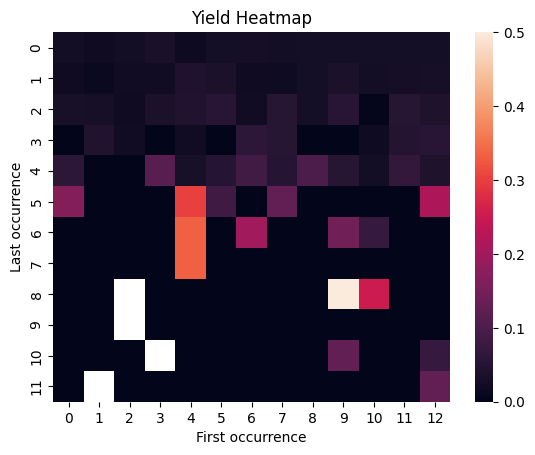

In [50]:
# Q: is there any pattern examining the local yield at varying fst_occ/lst_occ values?
# A: nothing particularly striking

subset = wforms[wforms["snd_batch"]][["fst_occ", "lst_occ", "status"]]
subset['bin_fst_occ'] = pd.cut(subset['fst_occ'], np.arange(0,370,28))
subset['bin_lst_occ'] = pd.cut(subset['lst_occ'], np.arange(0,370,1))
y = subset.pivot_table(values='status', index='bin_fst_occ', columns='bin_lst_occ', aggfunc=lambda xs: xs.eq(1).sum()/len(xs))

subset
ax = sns.heatmap(y)
ax.set_xlabel('First occurrence')
ax.set_ylabel('Last occurrence')
ax.set_title('Yield Heatmap')
plt.show()